In [1]:
# Let's create word vectors from a GoT dataset and analyse them to see semantic similarities
from __future__ import absolute_import, division, print_function
# Word encoding
import codecs
# Regex
import glob
# concurrency
import multiprocessing
# dealing with OS
import glob, os
# pretty printing
import pprint
# regular expression
import re
# natural language toolkit 
import nltk.data
# word 2 vec
import gensim.models.word2vec as w2v
# dimensionality reduction
import sklearn.manifold
# math
import numpy as np
# plotting
import matplotlib.pyplot as plt
# parse pandas
import pandas as pd
# visualization
import seaborn as sns

In [2]:
# Step 1: Process data
# clean data
#nltk.download()      # pretrained tokenizer
#nltk.download('stopwords')  # remove words like and, the, or

In [3]:
# Get book file names
book_filenames = sorted(glob.glob("got/*.txt"))
book_filenames

['got/got1.txt',
 'got/got2.txt',
 'got/got3.txt',
 'got/got4.txt',
 'got/got5.txt']

In [4]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, 'r', 'utf8') as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'got/got1.txt'...
Corpus is now 1586814 characters long

Reading 'got/got2.txt'...
Corpus is now 3341779 characters long

Reading 'got/got3.txt'...
Corpus is now 5626206 characters long

Reading 'got/got4.txt'...
Corpus is now 7327878 characters long

Reading 'got/got5.txt'...
Corpus is now 9612305 characters long



### Split the corpus into sentences

In [5]:
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

In [6]:
# tokenizer to split into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [7]:
# convert into a list of words
# remove unnecessary, split into words, no hyphens
# list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [8]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [9]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))


“Dead is dead,” he said.
['Dead', 'is', 'dead', 'he', 'said']


In [10]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,811,090 tokens


### Train Word2Vec

In [11]:
# Step 3: build model
# Once we have vectors

# 3 main tasks that vectors help with
# Distance, similarity, ranking

# Dimensionality of the resulting word vectors
num_features = 300

# Min word count threshold
min_word_count = 3

# Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()

# Context window length
context_size = 7

# Downsample setting for frequent words
downsampling = 1e-3

# Seed for the RNG, to make the results reproductible
seed = 1

In [12]:
thrones2vec = w2v.Word2Vec(
    sg = 1,
    seed=seed,
    workers=num_workers,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [13]:
thrones2vec.build_vocab(sentences)

In [14]:
# length of vector
print("Word2Vec vocabulary length: ", len(thrones2vec.wv.vocab))


Word2Vec vocabulary length:  16621


### Train & Save

In [15]:
# Reference https://github.com/hgrif/wiki-word2vec
params = {"total_examples":thrones2vec.corpus_count, "epochs":5 }
thrones2vec.train(sentences, **params)

(6990315, 9055450)

In [16]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [17]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

### Explore the trained model

In [18]:
# 300 dimensional vectors
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

### Compress the word vectors into 2D space and plot

In [20]:
X = thrones2vec.wv[thrones2vec.wv.vocab]

In [23]:
tsne = sklearn.manifold.TSNE(n_components = 2, 
                             early_exaggeration = 6,
                             learning_rate = 500,
                             n_iter = 2000,
                             verbose = True,
                             random_state = 2)
X_tsne = tsne.fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 16621
[t-SNE] Computed conditional probabilities for sample 2000 / 16621
[t-SNE] Computed conditional probabilities for sample 3000 / 16621
[t-SNE] Computed conditional probabilities for sample 4000 / 16621
[t-SNE] Computed conditional probabilities for sample 5000 / 16621
[t-SNE] Computed conditional probabilities for sample 6000 / 16621
[t-SNE] Computed conditional probabilities for sample 7000 / 16621
[t-SNE] Computed conditional probabilities for sample 8000 / 16621
[t-SNE] Computed conditional probabilities for sample 9000 / 16621
[t-SNE] Computed conditional probabilities for sample 10000 / 16621
[t-SNE] Computed conditional probabilities for sample 11000 / 16621
[t-SNE] Computed conditional probabilities for sample 12000 / 16621
[t-SNE] Computed conditional probabilities for sample 13000 / 16621
[t-SNE] Computed conditional probabilities 

In [56]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, X_tsne[thrones2vec.wv.vocab[word].index]) 
                    for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

# x_coords = X_tsne[:, 0]
# y_coords = X_tsne[:, 1]

# plt.rc("font", size=5)
# plt.figure(figsize=(16, 12), dpi=80)
# plt.scatter(x_coords[0], y_coords[0], s=800, marker="x", color="blue")
# plt.scatter(x_coords[1:], y_coords[1:], s=200, marker="x", color="red")
# for label, x, y in zip(w_labels, x_coords, y_coords):
#     plt.annotate(label.upper(), xy=(x, y), xytext=(0, 0), textcoords='offset points')
# plt.xlim(x_coords.min()-50, x_coords.max()+50)
# plt.ylim(y_coords.min()-50, y_coords.max()+50)
# filename = os.path.join("trained", word + "_tsne.png")
# plt.savefig(filename)
# plt.close()
 

In [57]:
points.head(10)

,word,x,y
0,walkways,-0.658577,0.421413
1,northerners,0.821471,0.452050
2,serjeant,-0.492778,1.440550
3,flies,1.733295,0.570888
4,ranged,1.605866,-0.014458
5,ripe,-0.465783,-0.076062
6,process,0.763474,1.176558
7,thud,-1.068628,0.840968
8,Harmune,-1.130919,0.052695
9,Alyssa,0.165012,0.729696


In [45]:
sns.set_context("poster")

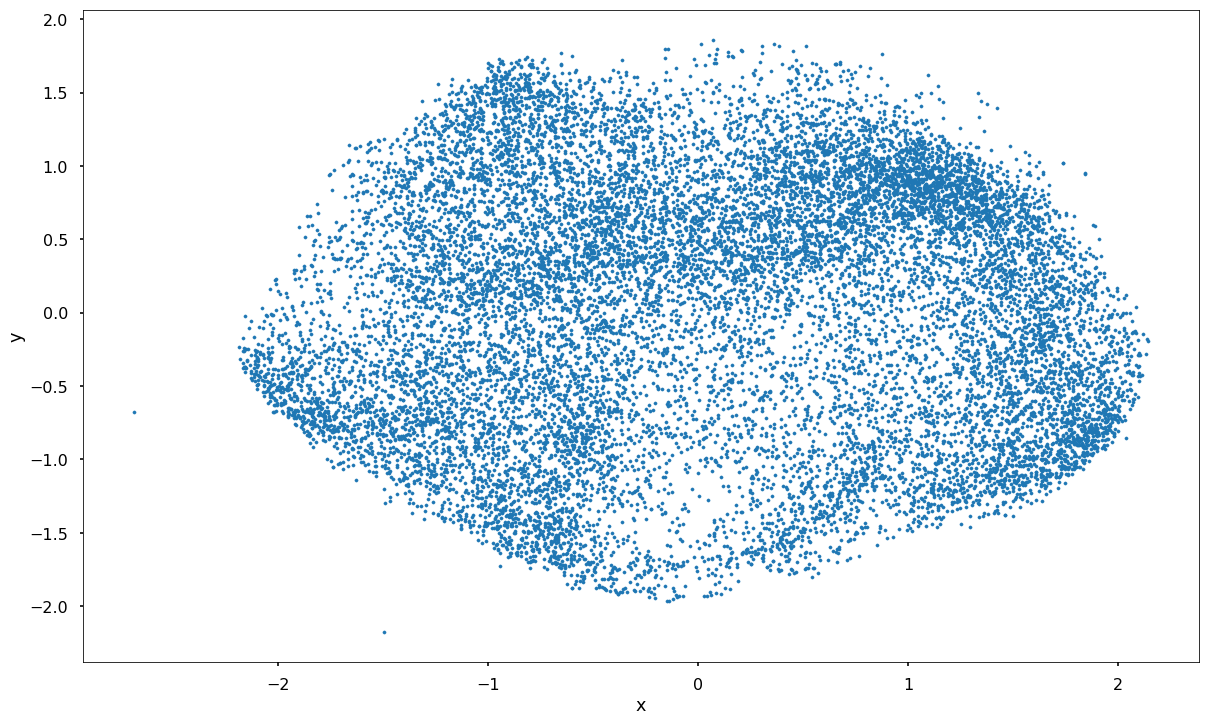

In [46]:
points.plot.scatter("x", "y", s=10, figsize=(20,12))

In [58]:
# zoom in
def plot_region(x_bounds, y_bounds):
    slice = points[
        ((x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1])) &
        ((y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]))
    ]
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 6))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)


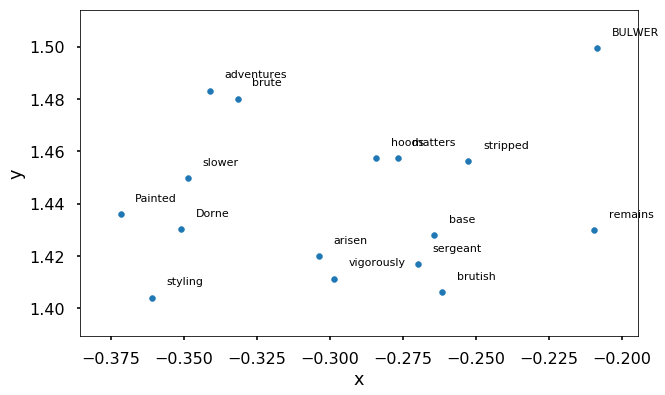

In [74]:
plot_region(x_bounds=(-0.4, -0.2),
y_bounds=(1.4, 1.5))


### Explore semantics

In [76]:
thrones2vec.wv.most_similar("Stark")

[('Eddard', 0.7461286187171936),
 ('Winterfell', 0.6855260729789734),
 ('Lyanna', 0.6756428480148315),
 ('beheaded', 0.6620096564292908),
 ('CATELYN', 0.6518804430961609),
 ('direwolf', 0.6375223398208618),
 ('Brandon', 0.6348937749862671),
 ('foster', 0.6330650448799133),
 ('plotted', 0.6274402141571045),
 ('companion', 0.623468279838562)]